In [56]:
import boto3
import pandas as pd
import sagemaker
from sagemaker import get_execution_role
import seaborn as sns
import matplotlib.pyplot as plt
import os
import io
import sagemaker.amazon.common as smac
import numpy as np

region = boto3.Session().region_name
sess = sagemaker.Session()

role = get_execution_role()
bucket='ds-challenge-sets'
prefix = 'Datasets'
stores_key = 'stores.csv'
transactions_key = 'transactions.csv'


store = 's3://{}/{}/{}'.format(bucket, prefix, stores_key)
transaction = 's3://{}/{}/{}'.format(bucket, prefix, transactions_key)

stores = pd.read_csv(store)
transactions = pd.read_csv(transaction)

region

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


'eu-west-2'

In [57]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [58]:
stores = transactions.merge(stores)
stores

,date,store_nbr,transactions,city,state,type,cluster
0,2013-01-01,25,770,Salinas,Santa Elena,D,1
1,2013-01-02,25,1038,Salinas,Santa Elena,D,1
2,2013-01-03,25,887,Salinas,Santa Elena,D,1
3,2013-01-04,25,1054,Salinas,Santa Elena,D,1
4,2013-01-05,25,1355,Salinas,Santa Elena,D,1
...,...,...,...,...,...,...,...
83483,2017-08-11,52,2957,Manta,Manabi,A,11
83484,2017-08-12,52,2804,Manta,Manabi,A,11
83485,2017-08-13,52,2433,Manta,Manabi,A,11
83486,2017-08-14,52,2074,Manta,Manabi,A,11


# EDA

<Figure size 1000x600 with 0 Axes>

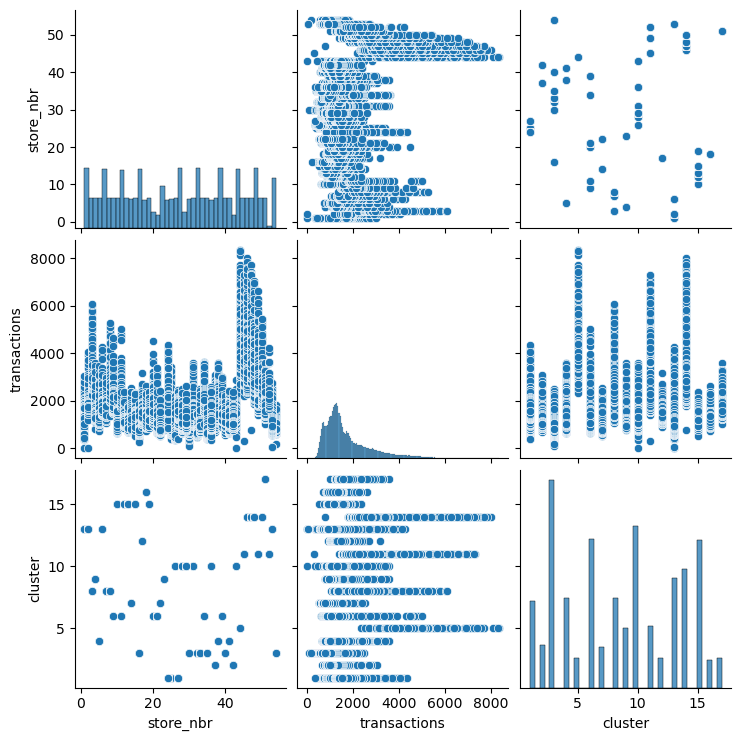

In [59]:
plt.figure(figsize=(10,6))

sns.pairplot(data=stores)

In [60]:
corr = stores.corr()
corr

/tmp/ipykernel_26611/1282714949.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = stores.corr()


,store_nbr,transactions,cluster
store_nbr,1.000000,0.189311,-0.078323
transactions,0.189311,1.000000,0.196014
cluster,-0.078323,0.196014,1.000000


<AxesSubplot: >

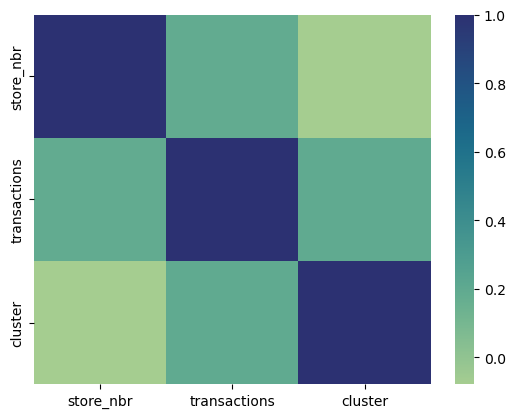

In [61]:
sns.heatmap(data=corr, cmap='crest')

<AxesSubplot: xlabel='transactions', ylabel='Count'>

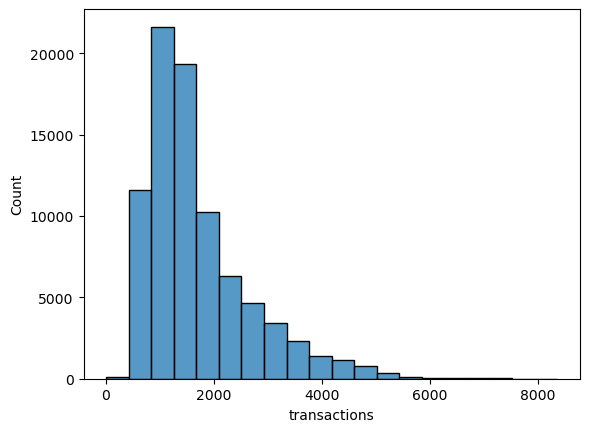

In [62]:
sns.histplot(stores['transactions'], bins=20)

<AxesSubplot: xlabel='city', ylabel='transactions'>

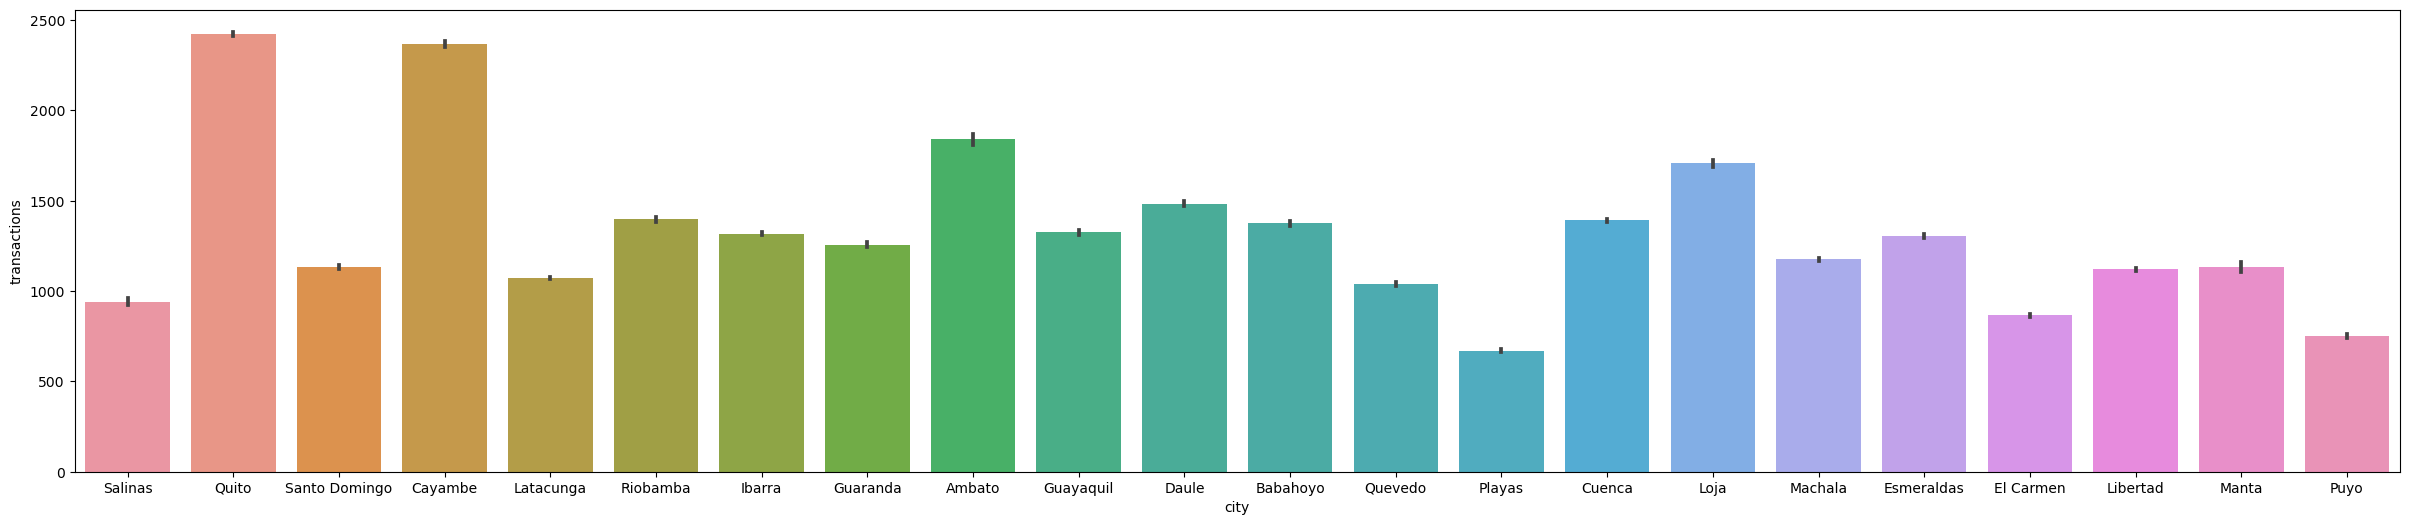

In [63]:
plt.figure(figsize=(30,6))

sns.barplot(data=stores, x='city', y='transactions')

<AxesSubplot: xlabel='state', ylabel='transactions'>

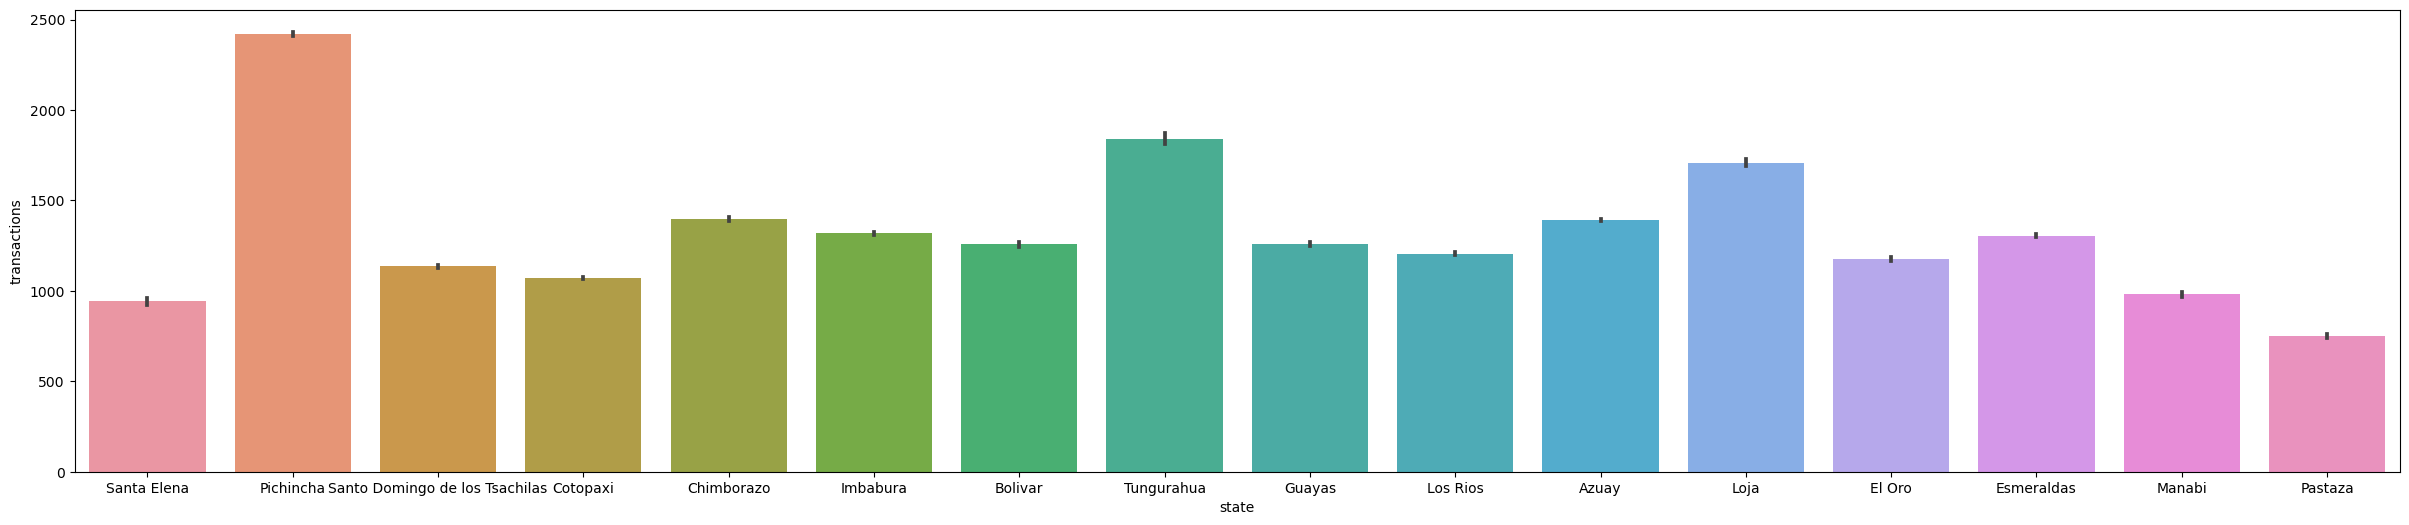

In [64]:
plt.figure(figsize=(30,6))

sns.barplot(data=stores, x='state', y='transactions')

month
1     12156198
2     11707934
3     12917913
4     12633531
5     13112679
6     12482179
7     12827206
8     11545571
9      9811819
10    10048234
11     9877873
12    12357808
Name: transactions, dtype: int64

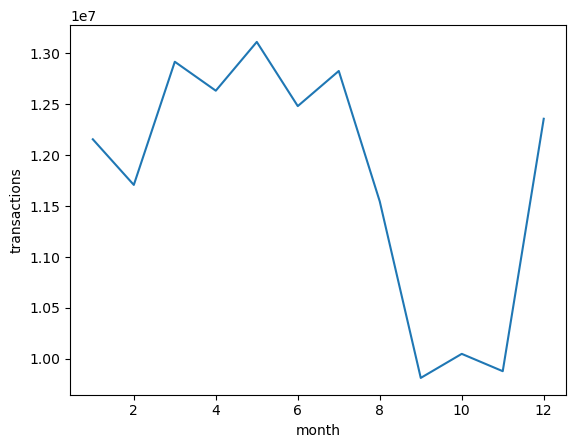

In [66]:
#plt.figure(figsize=(10,6))

stores['month'] = pd.DatetimeIndex(stores['date']).month

transaction_by_month = stores.groupby('month')['transactions'].sum()

sns.lineplot(transaction_by_month)

transaction_by_month

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<AxesSubplot: xlabel='year', ylabel='transactions'>

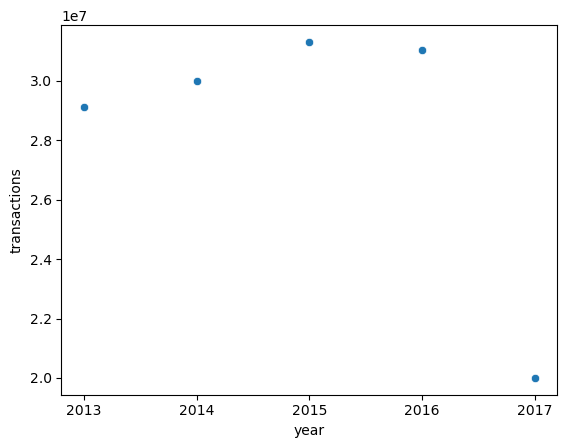

In [79]:
stores['year'] = pd.DatetimeIndex(stores['date']).year.astype(str)

transaction_by_year = stores.groupby('year')['transactions'].sum()

sns.lineplot(transaction_by_year)


day
1     4641199
2     4935067
3     4784612
4     4778409
5     4830056
6     4779955
7     4746095
8     4691106
9     4654772
10    4606177
11    4623145
12    4602717
13    4651202
14    4662215
15    4679289
16    4638036
17    4612435
18    4628107
19    4588958
20    4671517
21    4660793
22    4676359
23    4748592
24    4748107
25    4082555
26    4473970
27    4437801
28    4474840
29    4183771
30    4272047
31    2915041
Name: transactions, dtype: int64


<AxesSubplot: xlabel='day', ylabel='transactions'>

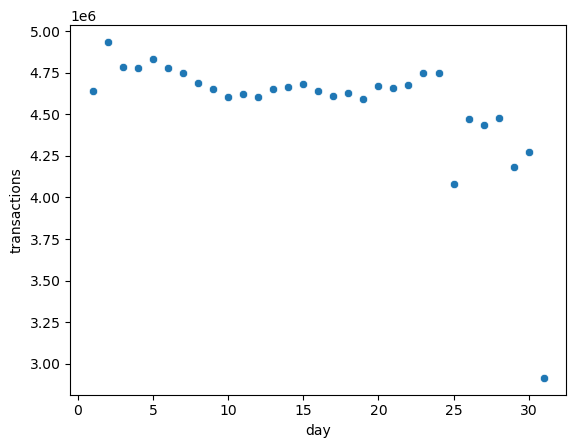

In [78]:
stores['day'] = pd.DatetimeIndex(stores['date']).day

transaction_by_day = stores.groupby('day')['transactions'].sum()

print(transaction_by_day)

sns.scatterplot(transaction_by_day)

# Cleaning

In [12]:
target = stores['transactions']
stores = stores.drop('transactions', axis = 1)
stores = stores.drop('date', axis=1)
stores = stores.drop('store_nbr', axis=1)

stores = pd.concat([target, stores], axis = 1)


In [13]:
city = pd.get_dummies(stores['city'])
states = pd.get_dummies(stores['state'])
types = pd.get_dummies(stores['type'])
month = pd.get_dummies(stores['month'])
year = pd.get_dummies(stores['year'])
cluster = pd.get_dummies(stores['cluster'])

stores = pd.concat([stores, city], axis=1)
stores = pd.concat([stores, states], axis=1)
stores = pd.concat([stores, types], axis=1)
stores = pd.concat([stores, month], axis=1)
stores = pd.concat([stores, year], axis=1)
stores = pd.concat([stores, cluster], axis=1)

stores = stores.drop(['city', 'state', 'type', 'year', 'month', 'cluster'], axis=1)
stores

,transactions,Ambato,Babahoyo,Cayambe,Cuenca,Daule,El Carmen,Esmeraldas,Guaranda,Guayaquil,...,8,9,10,11,12,13,14,15,16,17
0,770,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1038,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,887,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1054,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1355,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83483,2957,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
83484,2804,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
83485,2433,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
83486,2074,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [14]:
train_data, validation_data, test_data = np.split(
    stores.sample(frac=1, random_state=1729),
    [int(0.7 * len(stores)), int(0.9 * len(stores))],
)
train_data.to_csv("train.csv", header=False, index=False)
validation_data.to_csv("validation.csv", header=False, index=False)

train_data

,transactions,Ambato,Babahoyo,Cayambe,Cuenca,Daule,El Carmen,Esmeraldas,Guaranda,Guayaquil,...,8,9,10,11,12,13,14,15,16,17
36241,2003,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
78460,586,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
54265,1528,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35537,2897,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
65595,4758,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58237,1136,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25551,1408,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
15936,2070,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40440,902,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0


In [15]:
bucket = sagemaker.Session().default_bucket()
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

In [16]:
bucket

'sagemaker-eu-west-2-866647877267'

In [17]:
from sagemaker import image_uris
from sagemaker.inputs import TrainingInput

container = sagemaker.image_uris.retrieve("xgboost", sess.boto_region_name, "1.5-1")

s3_input_train = TrainingInput(
    s3_data="s3://{}/{}/train".format(bucket, prefix), content_type="csv"
)
s3_input_validation = TrainingInput(
    s3_data="s3://{}/{}/validation/".format(bucket, prefix), content_type="csv"
)

In [18]:
xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
)
xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    verbosity=0,
    objective="reg:squarederror",
    num_round=100,
)

xgb.fit({"train": s3_input_train, "validation": s3_input_validation})

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-03-16-11-42-40-490


2023-03-16 11:42:40 Starting - Starting the training job...
2023-03-16 11:43:11 Starting - Preparing the instances for training............
2023-03-16 11:45:12 Downloading - Downloading input data......
2023-03-16 11:45:43 Training - Downloading the training image...
2023-03-16 11:46:23 Training - Training image download completed. Training in progress..[2023-03-16 11:46:40.697 ip-10-0-86-74.eu-west-2.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-03-16 11:46:40.781 ip-10-0-86-74.eu-west-2.compute.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2023-03-16:11:46:41:INFO] Imported framework sagemaker_xgboost_container.training
[2023-03-16:11:46:41:INFO] Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
[2023-03-16:11:46:41:INFO] No GPUs detected (normal if no gpus installed)
[2023-03-16:11:46:41:INFO] Running XGBoost Sagemaker in algorithm mode
[2023-03-16:11:46:41:INFO] Determin

In [19]:
from sagemaker.serializers import CSVSerializer

xgb_predictor = xgb.deploy(
    initial_instance_count=1, instance_type="ml.m4.xlarge", serializer=CSVSerializer()
)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-03-16-11-47-25-188
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-03-16-11-47-25-188
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-03-16-11-47-25-188


------!

In [20]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ""
    for array in split_array:
        predictions = "".join([predictions, xgb_predictor.predict(array).decode("utf-8")])

    return predictions.split("\n")[:-1]

predictions = predict(test_data.values[:, 1:])
predictions

['1700.89111328125',
 '2495.9892578125',
 '1065.4232177734375',
 '1498.09326171875',
 '756.9893188476562',
 '3351.318115234375',
 '912.6353759765625',
 '1767.8775634765625',
 '1697.1689453125',
 '2434.146728515625',
 '1456.093017578125',
 '1803.8074951171875',
 '2047.76220703125',
 '954.02197265625',
 '768.6753540039062',
 '1270.644287109375',
 '4251.6552734375',
 '3461.835205078125',
 '1205.64697265625',
 '1205.64697265625',
 '1165.4158935546875',
 '2050.660888671875',
 '1786.95458984375',
 '632.312255859375',
 '1444.0421142578125',
 '1157.09716796875',
 '1758.1424560546875',
 '1448.8017578125',
 '965.927734375',
 '1232.514404296875',
 '1340.324951171875',
 '761.055419921875',
 '1873.341796875',
 '722.7470092773438',
 '1719.8897705078125',
 '675.7556762695312',
 '782.5811767578125',
 '2608.542724609375',
 '1360.8673095703125',
 '566.4595947265625',
 '1269.20556640625',
 '2480.230224609375',
 '4231.91064453125',
 '3304.1474609375',
 '1098.5816650390625',
 '3206.328857421875',
 '2125.27

In [44]:
from sklearn.metrics import mean_absolute_error, r2_score
predictions = np.array(predictions, dtype=float)
mae_score = mean_absolute_error(test_data['transactions'], predictions)
r2 = r2_score(test_data['transactions'], predictions)
print("The Mean Absolute Error of our Model is {}".format(round(score, 2)))
print("The R^2 Error of our Model is {}".format(round(r2, 2)))

The Mean Absolute Error of our Model is 253.83
The R^2 Error of our Model is 0.84


In [41]:
tuning_job_config = {
    "ParameterRanges": {
      "ContinuousParameterRanges": [
        {
          "MaxValue": "1",
          "MinValue": "0",
          "Name": "eta"
        },
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "min_child_weight"
        }
      ],
      "IntegerParameterRanges": [
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "max_depth"
        }
      ]
    },
    "ResourceLimits": {
      "MaxNumberOfTrainingJobs": 20,
      "MaxParallelTrainingJobs": 3
    },
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {
      "MetricName": "validation:mae",
      "Type": "Minimize"
    },
    "RandomSeed" : 123
  }

In [42]:
s3_input_train = 's3://{}/{}/train'.format(bucket, prefix)
s3_input_validation ='s3://{}/{}/validation/'.format(bucket, prefix)

training_job_definition = {
    "AlgorithmSpecification": {
      "TrainingImage": container,
      "TrainingInputMode": "File"
    },
    "InputDataConfig": [
      {
        "ChannelName": "train",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_input_train
          }
        }
      },
      {
        "ChannelName": "validation",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_input_validation
          }
        }
      }
    ],
    "OutputDataConfig": {
      "S3OutputPath": "s3://{}/{}/output".format(bucket,prefix)
    },
    "ResourceConfig": {
      "InstanceCount": 1,
      "InstanceType": "ml.m4.xlarge",
      "VolumeSizeInGB": 10
    },
    "RoleArn": role,
    "StaticHyperParameters": {
      "eval_metric": "mae",
      "num_round": "100",
      "objective": "reg:squarederror",
      "rate_drop": "0.3",
      "tweedie_variance_power": "1.4"
    },
    "StoppingCondition": {
      "MaxRuntimeInSeconds": 43200
    }
}

In [50]:
smclient = boto3.Session().client('sagemaker')
tuning_job_name = "DS-CHALLE4"
#tuner = smclient.create_hyper_parameter_tuning_job(HyperParameterTuningJobName = tuning_job_name,
#                                           HyperParameterTuningJobConfig = tuning_job_config,
#                                           TrainingJobDefinition = training_job_definition)

best_overall_training_job = smclient.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)["BestTrainingJob"]

best_overall_training_job

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


{'TrainingJobName': 'DS-CHALLE4-002-6888a7ba',
 'TrainingJobArn': 'arn:aws:sagemaker:eu-west-2:866647877267:training-job/DS-CHALLE4-002-6888a7ba',
 'CreationTime': datetime.datetime(2023, 3, 16, 12, 44, 4, tzinfo=tzlocal()),
 'TrainingStartTime': datetime.datetime(2023, 3, 16, 12, 45, 36, tzinfo=tzlocal()),
 'TrainingEndTime': datetime.datetime(2023, 3, 16, 12, 47, 28, tzinfo=tzlocal()),
 'TrainingJobStatus': 'Completed',
 'TunedHyperParameters': {'eta': '0.2513529496050715',
  'max_depth': '5',
  'min_child_weight': '6.501753251206771'},
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:mae',
  'Value': 244.7217559814453},
 'ObjectiveStatus': 'Succeeded'}

In [53]:
xgb_predictor.delete_model()
xgb_predictor.delete_endpoint()

ClientError: An error occurred (ValidationException) when calling the DescribeEndpointConfig operation: Could not find endpoint configuration "arn:aws:sagemaker:eu-west-2:866647877267:endpoint-config/sagemaker-xgboost-2023-03-16-11-47-25-188".